In [573]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import seaborn as sns 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sales-forecasting/train.csv


In [574]:
data=pd.read_csv('/kaggle/input/sales-forecasting/train.csv')
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [575]:
data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

In [576]:
for i in data.columns:
    print (data[i].dtype)

int64
object
object
object
object
object
object
object
object
object
object
float64
object
object
object
object
object
float64


In [577]:
data["Country"].unique

<bound method Series.unique of 0       United States
1       United States
2       United States
3       United States
4       United States
            ...      
9795    United States
9796    United States
9797    United States
9798    United States
9799    United States
Name: Country, Length: 9800, dtype: object>

In [578]:
data_new = data.drop(columns=['Row ID', 'Order ID', 'Segment', 'Country', 
                              'Customer ID', 'Customer Name', 
                              'Region', 'Postal Code', 'Product ID','Product Name'])

In [579]:
data_new.head()

,Order Date,Ship Date,Ship Mode,City,State,Category,Sub-Category,Sales
0,08/11/2017,11/11/2017,Second Class,Henderson,Kentucky,Furniture,Bookcases,261.9600
1,08/11/2017,11/11/2017,Second Class,Henderson,Kentucky,Furniture,Chairs,731.9400
2,12/06/2017,16/06/2017,Second Class,Los Angeles,California,Office Supplies,Labels,14.6200
3,11/10/2016,18/10/2016,Standard Class,Fort Lauderdale,Florida,Furniture,Tables,957.5775
4,11/10/2016,18/10/2016,Standard Class,Fort Lauderdale,Florida,Office Supplies,Storage,22.3680


In [580]:
for i in data_new.columns:
    print (data_new[i].dtype)

object
object
object
object
object
object
object
float64


In [581]:
count_encoder = ce.CountEncoder()
# Initialize and apply LabelEncoder to 'Ship Mode'
label_encoder = LabelEncoder()
data_new['Ship Mode'] = label_encoder.fit_transform(data_new['Ship Mode'])
data_new["Category"]= label_encoder.fit_transform(data_new['Category'])
# Initialize and apply CountEncoder to 'City', 'State', and 'Sub Category'
count_encoder = ce.CountEncoder()
data_new[['City', 'State', 'Sub-Category']] = count_encoder.fit_transform(data_new[['City', 'State', 'Sub-Category']])


In [582]:
for i in data_new.columns:
    print (data_new[i].dtype)

print(data_new.columns)

object
object
int64
int64
int64
int64
int64
float64
Index(['Order Date', 'Ship Date', 'Ship Mode', 'City', 'State', 'Category',
       'Sub-Category', 'Sales'],
      dtype='object')


In [583]:
data_new['Order Date'] = pd.to_datetime(data_new['Order Date'], format='%d/%m/%Y')
data_new['Ship Date'] = pd.to_datetime(data_new['Ship Date'], format='%d/%m/%Y')


In [584]:
# For Order Date
data_new['Order_Year'] = data_new['Order Date'].dt.year
data_new['Order_Month'] = data_new['Order Date'].dt.month
data_new['Order_Day'] = data_new['Order Date'].dt.day
data_new['Order_Weekday'] = data_new['Order Date'].dt.weekday  # Monday = 0, Sunday = 6
data_new['Order_Quarter'] = data_new['Order Date'].dt.quarter

# For Ship Date
data_new['Ship_Year'] = data_new['Ship Date'].dt.year
data_new['Ship_Month'] = data_new['Ship Date'].dt.month
data_new['Ship_Day'] = data_new['Ship Date'].dt.day
data_new['Ship_Weekday'] = data_new['Ship Date'].dt.weekday  # Monday = 0, Sunday = 6
data_new['Ship_Quarter'] = data_new['Ship Date'].dt.quarter


In [585]:
# Order Date Cyclical Encoding
data_new['Order_Month_sin'] = np.sin(2 * np.pi * data_new['Order_Month'] / 12)
data_new['Order_Month_cos'] = np.cos(2 * np.pi * data_new['Order_Month'] / 12)

data_new['Order_Weekday_sin'] = np.sin(2 * np.pi * data_new['Order_Weekday'] / 7)
data_new['Order_Weekday_cos'] = np.cos(2 * np.pi * data_new['Order_Weekday'] / 7)

# Ship Date Cyclical Encoding
data_new['Ship_Month_sin'] = np.sin(2 * np.pi * data_new['Ship_Month'] / 12)
data_new['Ship_Month_cos'] = np.cos(2 * np.pi * data_new['Ship_Month'] / 12)

data_new['Ship_Weekday_sin'] = np.sin(2 * np.pi * data_new['Ship_Weekday'] / 7)
data_new['Ship_Weekday_cos'] = np.cos(2 * np.pi * data_new['Ship_Weekday'] / 7)

In [586]:
data_new['Days_to_Ship'] = (data_new['Ship Date'] - data_new['Order Date']).dt.days


In [587]:
data_new=data_new.drop(columns=['Order Date','Ship Date'])

In [588]:
for i in data_new.columns:
    print (data_new[i].dtype)

print(data_new.columns)

int64
int64
int64
int64
int64
float64
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
float64
float64
float64
float64
float64
float64
float64
float64
int64
Index(['Ship Mode', 'City', 'State', 'Category', 'Sub-Category', 'Sales',
       'Order_Year', 'Order_Month', 'Order_Day', 'Order_Weekday',
       'Order_Quarter', 'Ship_Year', 'Ship_Month', 'Ship_Day', 'Ship_Weekday',
       'Ship_Quarter', 'Order_Month_sin', 'Order_Month_cos',
       'Order_Weekday_sin', 'Order_Weekday_cos', 'Ship_Month_sin',
       'Ship_Month_cos', 'Ship_Weekday_sin', 'Ship_Weekday_cos',
       'Days_to_Ship'],
      dtype='object')


In [589]:
for i in data_new.columns:
    print (data_new[i].dtype)

int64
int64
int64
int64
int64
float64
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
float64
float64
float64
float64
float64
float64
float64
float64
int64


In [590]:
print(data_new.columns)

Index(['Ship Mode', 'City', 'State', 'Category', 'Sub-Category', 'Sales',
       'Order_Year', 'Order_Month', 'Order_Day', 'Order_Weekday',
       'Order_Quarter', 'Ship_Year', 'Ship_Month', 'Ship_Day', 'Ship_Weekday',
       'Ship_Quarter', 'Order_Month_sin', 'Order_Month_cos',
       'Order_Weekday_sin', 'Order_Weekday_cos', 'Ship_Month_sin',
       'Ship_Month_cos', 'Ship_Weekday_sin', 'Ship_Weekday_cos',
       'Days_to_Ship'],
      dtype='object')


In [591]:
data_new["Category"].unique()

array([0, 1, 2])

In [592]:
data_new.corr(method ='kendall')

,Ship Mode,City,State,Category,Sub-Category,Sales,Order_Year,Order_Month,Order_Day,Order_Weekday,...,Ship_Quarter,Order_Month_sin,Order_Month_cos,Order_Weekday_sin,Order_Weekday_cos,Ship_Month_sin,Ship_Month_cos,Ship_Weekday_sin,Ship_Weekday_cos,Days_to_Ship
Ship Mode,1.000000,0.005534,-0.013542,-0.004100,0.007491,-0.008016,-0.037450,-0.009201,0.015378,0.031514,...,-0.017655,0.006507,0.001285,-0.001814,-0.020697,0.009147,0.001877,-0.084387,-0.046247,0.634401
City,0.005534,1.000000,0.409827,0.009879,-0.000167,0.010473,0.008679,0.002226,-0.003648,-0.017588,...,0.009241,-0.006681,-0.009343,0.032256,-0.005699,-0.008020,-0.006590,0.009773,0.014394,0.004125
State,-0.013542,0.409827,1.000000,-0.009215,-0.012009,-0.003776,0.005328,0.010731,-0.004200,-0.012574,...,0.018731,-0.002337,0.001401,0.011005,-0.008140,-0.001907,0.002726,0.020559,0.012186,-0.022148
Category,-0.004100,0.009879,-0.009215,1.000000,0.030796,0.004105,0.004069,-0.011836,-0.011217,-0.003536,...,-0.013098,0.002637,-0.008323,-0.000096,0.003303,0.000462,-0.008535,-0.014450,0.004003,-0.001252
Sub-Category,0.007491,-0.000167,-0.012009,0.030796,1.000000,-0.207149,0.011890,-0.004718,-0.005534,0.005810,...,-0.006537,0.002129,-0.008923,-0.002444,-0.002454,0.001274,-0.011267,0.005813,0.001768,0.010527
Sales,-0.008016,0.010473,-0.003776,0.004105,-0.207149,1.000000,-0.004195,0.011422,0.001787,-0.001305,...,0.013394,0.004741,0.015283,0.003728,0.003571,0.003217,0.016372,-0.006624,0.012319,-0.010282
Order_Year,-0.037450,0.008679,0.005328,0.004069,0.011890,-0.004195,1.000000,-0.013257,-0.014525,0.017505,...,-0.008749,0.006353,-0.004356,-0.077139,-0.025127,0.002089,-0.004020,0.049542,-0.004337,-0.018351
Order_Month,-0.009201,0.002226,0.010731,-0.011836,-0.004718,0.011422,-0.013257,1.000000,-0.025418,0.025416,...,0.830237,-0.387046,0.500559,-0.024659,-0.018682,-0.361970,0.517220,0.006876,0.007699,0.001501
Order_Day,0.015378,-0.003648,-0.004200,-0.011217,-0.005534,0.001787,-0.014525,-0.025418,1.000000,-0.024865,...,-0.037992,0.005859,-0.029520,0.026013,0.010312,0.015631,-0.020784,-0.012549,0.004029,0.008448
Order_Weekday,0.031514,-0.017588,-0.012574,-0.003536,0.005810,-0.001305,0.017505,0.025416,-0.024865,1.000000,...,0.019192,-0.009695,0.005760,-0.447538,-0.470756,-0.010154,0.010319,0.159056,-0.054940,0.015519


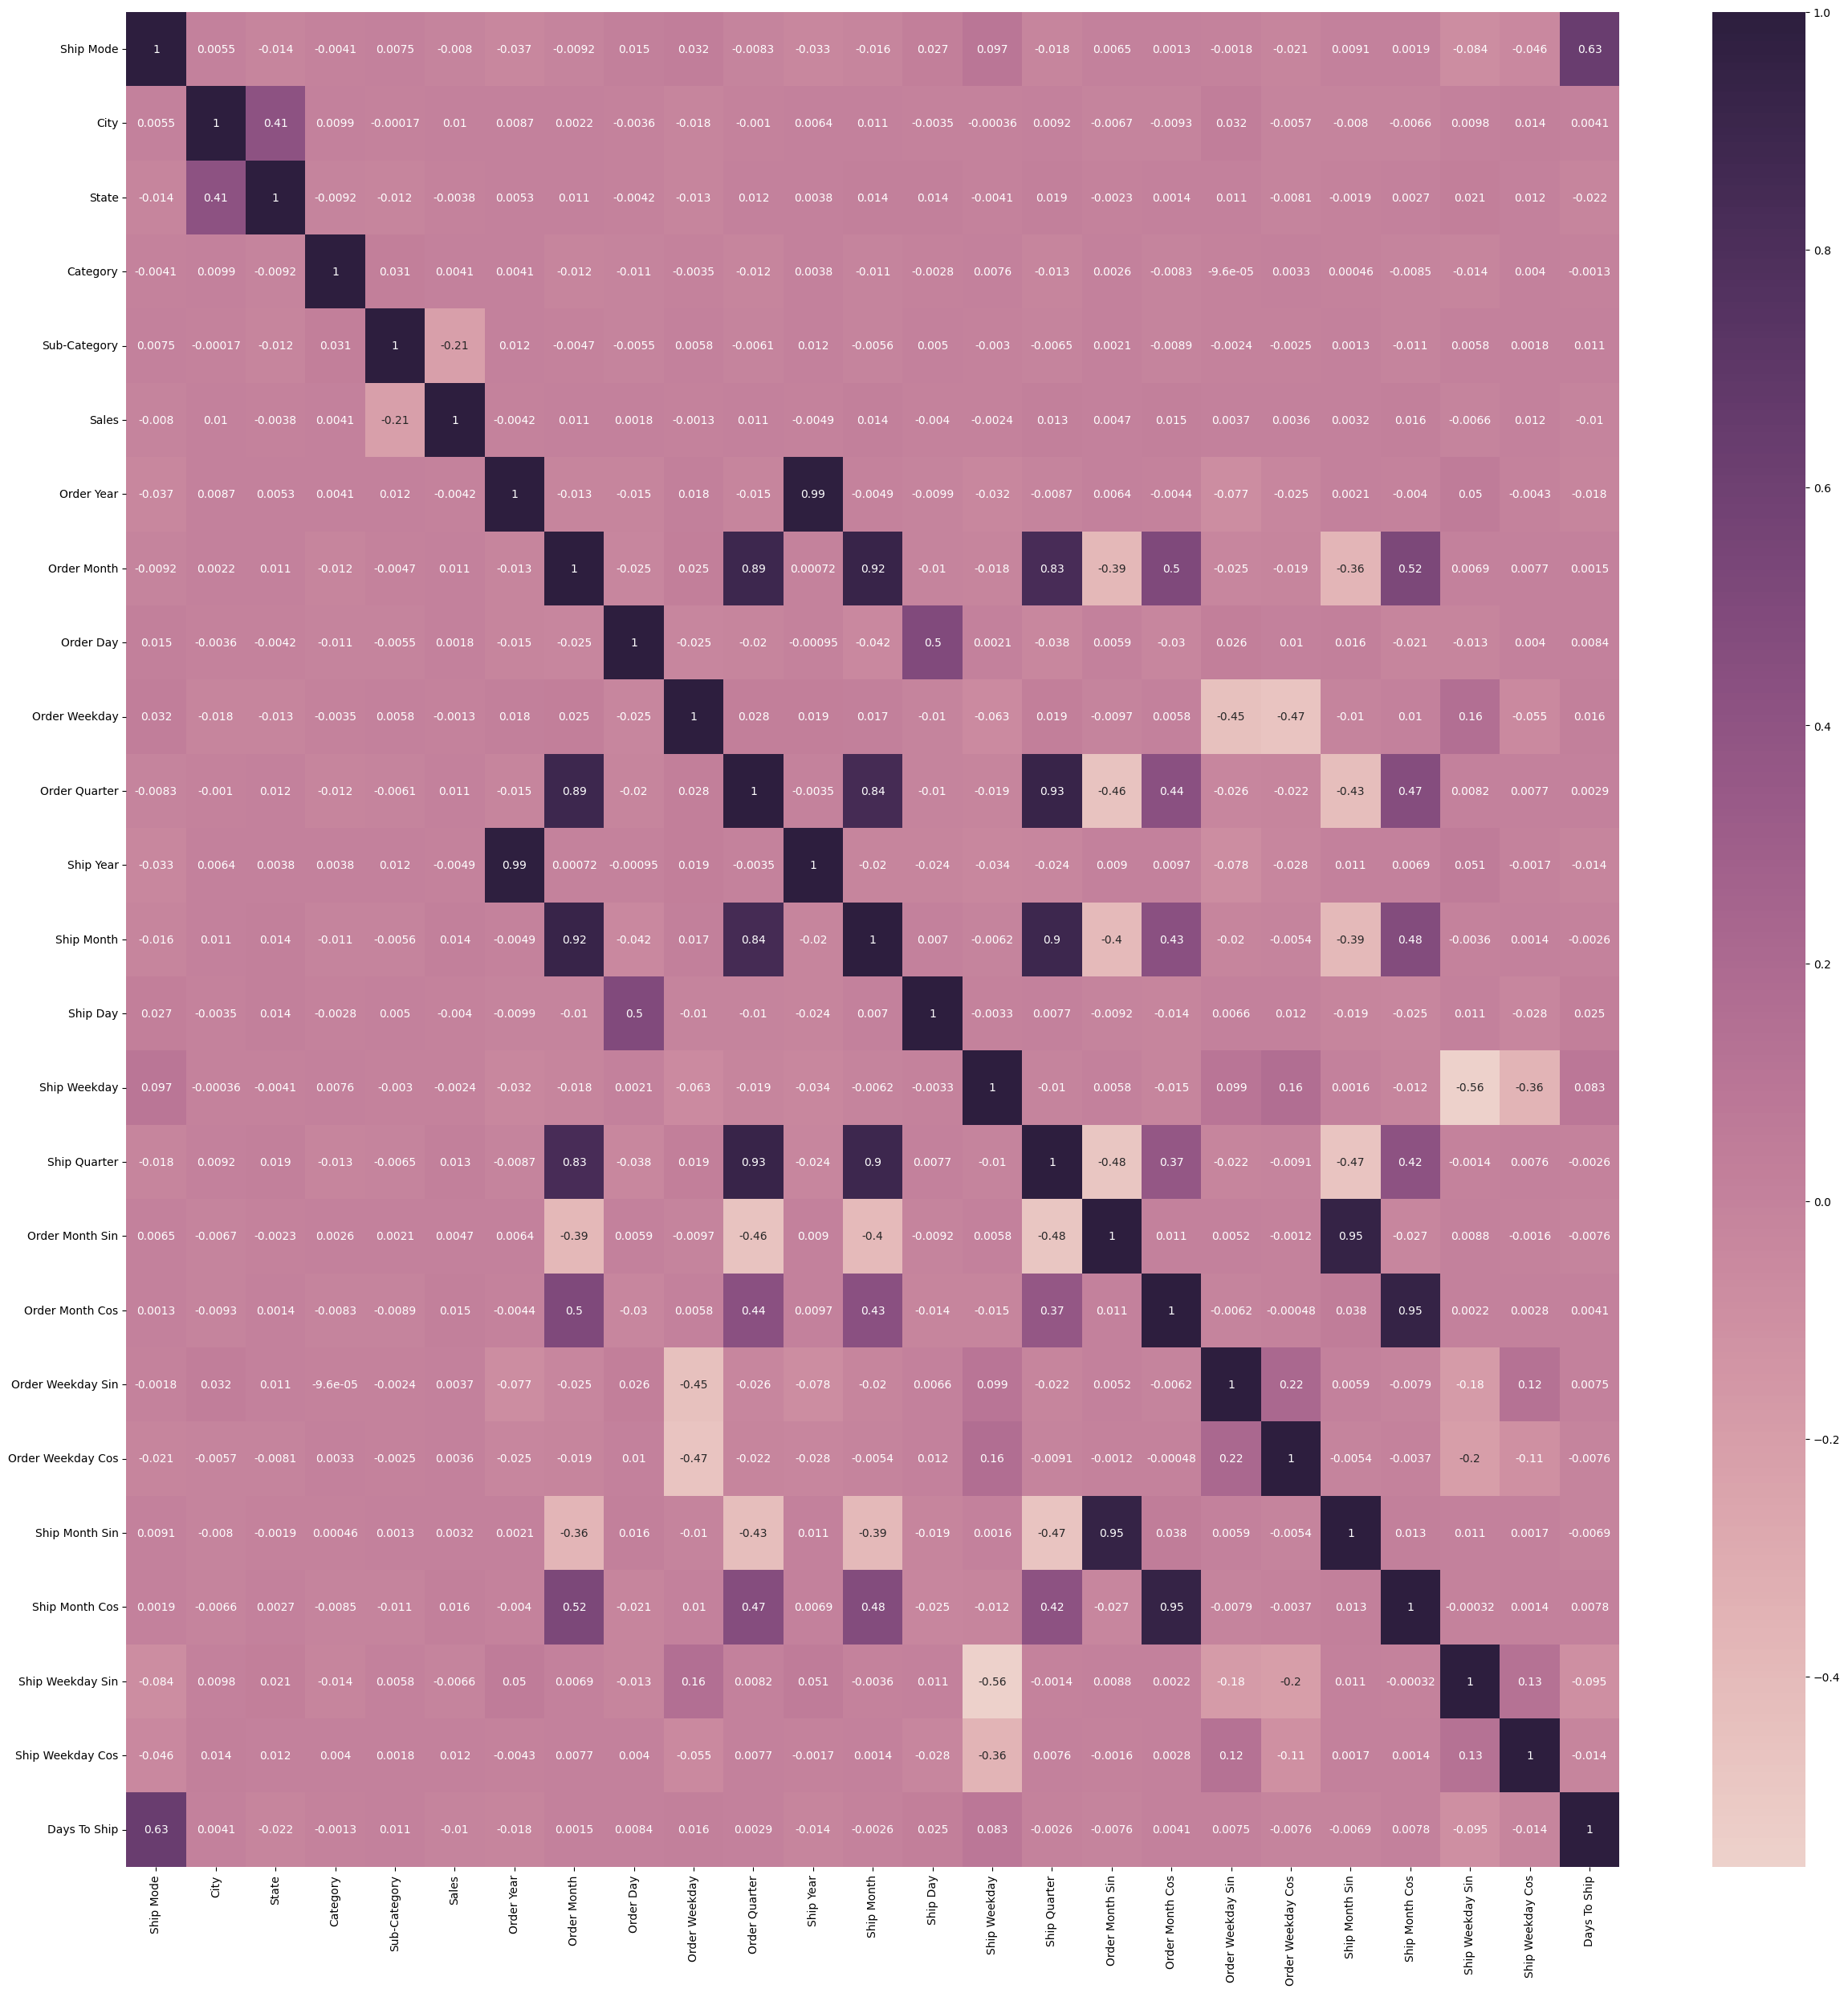

In [593]:
h_labels = [x.replace('_', ' ').title() for x in 
            list(data_new.select_dtypes(include=['int32', 'int64','float64']).columns.values)]

fig, ax = plt.subplots(figsize=(30,30))
_ = sns.heatmap(data_new.corr(method ='kendall'), annot=True, xticklabels=h_labels, yticklabels=h_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

In [594]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming data_new is your DataFrame with existing features
# List of columns that you want to include for clustering (numeric columns only)
# Exclude categorical columns like 'Ship Mode', 'City', 'State', etc. for clustering
# In this case, we assume that 'Sales', 'Order_Year', 'Order_Month', etc. are numeric

# Select numeric columns for clustering
numeric_columns = ['Sales', 'Order_Year', 'Order_Month', 'Order_Day', 'Order_Weekday', 
                   'Order_Quarter', 'Ship_Year', 'Ship_Month', 'Ship_Day', 'Ship_Weekday', 
                   'Ship_Quarter', 'Order_Month_sin', 'Order_Month_cos', 
                   'Order_Weekday_sin', 'Order_Weekday_cos', 'Ship_Month_sin',
                   'Ship_Month_cos', 'Ship_Weekday_sin', 'Ship_Weekday_cos', 'Days_to_Ship']

# Extract the numeric data for clustering
X = data_new[numeric_columns]

# Step 1: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Set the number of clusters (e.g., 4)
kmeans.fit(X_scaled)

# Step 3: Get the cluster labels
cluster_labels = kmeans.labels_

# Step 4: Add the cluster labels as a new feature to the DataFrame
data_new['Cluster_Label'] = cluster_labels

# Now, data_new contains the original features along with the K-Means cluster labels
print(data_new.head())


   Ship Mode  City  State  Category  Sub-Category     Sales  Order_Year  \
0          2    51    137         0           226  261.9600        2017   
1          2    51    137         0           607  731.9400        2017   
2          2   728   1946         1           357   14.6200        2017   
3          3    13    373         0           314  957.5775        2016   
4          3    13    373         1           832   22.3680        2016   

   Order_Month  Order_Day  Order_Weekday  ...  Order_Month_sin  \
0           11          8              2  ...    -5.000000e-01   
1           11          8              2  ...    -5.000000e-01   
2            6         12              0  ...     1.224647e-16   
3           10         11              1  ...    -8.660254e-01   
4           10         11              1  ...    -8.660254e-01   

   Order_Month_cos  Order_Weekday_sin  Order_Weekday_cos  Ship_Month_sin  \
0         0.866025           0.974928          -0.222521   -5.000000e-01   


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [595]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)  # degree=2 for quadratic features
poly_features = poly.fit_transform(data_new[['Sales', 'Order_Year']])
poly_feature_names = poly.get_feature_names_out(['Sales', 'Order_Year'])

data_new[poly_feature_names] = poly_features


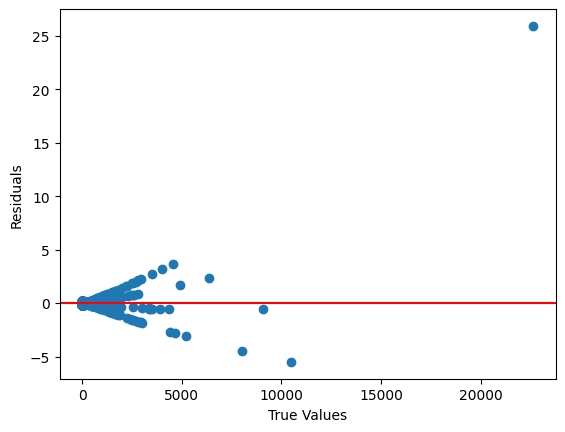

In [596]:
Y=data_new["Sales"]
X=data_new.drop(columns=["Sales"])
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit a multiple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Check residuals
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()

In [597]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [598]:
print("y_test sample:", y_test[:10])



y_test sample: 532      47.940
872      11.360
1149     10.950
2287     17.480
4038     21.120
1726     88.832
4989      6.672
4228     22.480
6664    251.580
7598     38.256
Name: Sales, dtype: float64


In [599]:
# Make predictions
y_pred = clf.predict(X_test)


In [600]:
print("y_pred sample:", y_pred[:10])
print("y_test dtype:", y_test.dtype)
print("y_pred dtype:", y_pred.dtype)

y_pred sample: [ 47.952  11.36   10.95   17.48   21.12   88.8     6.672  22.5   251.79
  38.272]
y_test dtype: float64
y_pred dtype: float64


In [601]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")  # How well the model explains the variance

Mean Squared Error (MSE): 42656.53
R² Score: 0.94


In [602]:

from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [603]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")  # How well the model explains the variance

Mean Squared Error (MSE): 111947.60
R² Score: 0.83


In [604]:
import pandas as pd

# Assuming 'data' is your DataFrame
nan_values = data_new.isna()  # This will return a DataFrame of the same shape with True for NaN values

# To find rows with any NaN values:
rows_with_nan = data_new[nan_values.any(axis=1)]

# To find columns with any NaN values:
columns_with_nan = data_new.columns[nan_values.any(axis=0)]

# To count NaNs in the entire dataset:
nan_count = nan_values.sum().sum()

# To count NaNs per column:
nan_count_per_column = nan_values.sum()

# Output results
print("Rows with NaN values:")
print(rows_with_nan)

print("\nColumns with NaN values:")
print(columns_with_nan)

print("\nTotal number of NaN values in the dataset:", nan_count)

print("\nNaN values per column:")
print(nan_count_per_column)


Rows with NaN values:
Empty DataFrame
Columns: [Ship Mode, City, State, Category, Sub-Category, Sales, Order_Year, Order_Month, Order_Day, Order_Weekday, Order_Quarter, Ship_Year, Ship_Month, Ship_Day, Ship_Weekday, Ship_Quarter, Order_Month_sin, Order_Month_cos, Order_Weekday_sin, Order_Weekday_cos, Ship_Month_sin, Ship_Month_cos, Ship_Weekday_sin, Ship_Weekday_cos, Days_to_Ship, Cluster_Label, 1, Sales^2, Sales Order_Year, Order_Year^2]
Index: []

[0 rows x 30 columns]

Columns with NaN values:
Index([], dtype='object')

Total number of NaN values in the dataset: 0

NaN values per column:
Ship Mode            0
City                 0
State                0
Category             0
Sub-Category         0
Sales                0
Order_Year           0
Order_Month          0
Order_Day            0
Order_Weekday        0
Order_Quarter        0
Ship_Year            0
Ship_Month           0
Ship_Day             0
Ship_Weekday         0
Ship_Quarter         0
Order_Month_sin      0
Order_Month

In [605]:
from scipy.stats import zscore
import numpy as np

z_scores = np.abs(zscore(data_new))
outliers = (z_scores > 3)  # You can adjust the threshold
data_outliers = data_new[outliers]


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [606]:
# Check the outliers mask (True indicates outliers)
print(outliers)

# Get the rows in the dataset that are considered outliers
print(data_outliers)

# Optionally, you can check the percentage of outliers in the data
print(f"Percentage of outliers: {np.mean(outliers) * 100:.2f}%")


      Ship Mode   City  State  Category  Sub-Category  Sales  Order_Year  \
0         False  False  False     False         False  False       False   
1         False  False  False     False         False  False       False   
2         False  False  False     False         False  False       False   
3         False  False  False     False         False  False       False   
4         False  False  False     False         False  False       False   
...         ...    ...    ...       ...           ...    ...         ...   
9795      False  False  False     False         False  False       False   
9796      False  False  False     False         False  False       False   
9797      False  False  False     False         False  False       False   
9798      False  False  False     False         False  False       False   
9799      False  False  False     False         False  False       False   

      Order_Month  Order_Day  Order_Weekday  ...  Ship_Month_sin  \
0           False  

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [607]:
from keras.models import Sequential
from keras.layers import Dense

# Define the autoencoder architecture
autoencoder = Sequential()

# Encoder part
autoencoder.add(Dense(128, activation='relu', input_dim=29))  # input_dim should match X_train's feature size
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(32, activation='relu'))

# Bottleneck (latent representation)
autoencoder.add(Dense(2, activation='linear'))  # 2-dimensional bottleneck

# Decoder part (reconstructing the original input)
autoencoder.add(Dense(32, activation='relu'))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(29, activation='sigmoid'))  # Output layer should have 24 units to match the input

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1422113243136.0000
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1212026978304.0000
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1784580276224.0000
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1250830057472.0000
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1338039205888.0000
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1012956004352.0000
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1184468172800.0000
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1594620772352.0000
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2120058011648.0000
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1279112249344.0000
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2678925557760.0000 
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1773881393152.0000
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1156280483840

In [608]:
autoencoder.evaluate(X_test, X_test)  # Again, X_test and y_test are the same for the autoencoder


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3129180684288.0000


5830875283456.0

In [609]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [610]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")  # How well the model explains the variance

Mean Squared Error (MSE): 111947.60
R² Score: 0.83


In [614]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Scale the features using StandardScaler (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Build the Neural Network Model
model = Sequential()

# Input layer (Number of input features should match the number of features in X_train)
model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))  # 64 neurons, ReLU activation
model.add(Dense(32, activation='relu'))  # Hidden layer with 32 neurons
model.add(Dense(1))  # Output layer (single value for regression)

# Step 3: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Step 5: Evaluate the model
y_pred = model.predict(X_test_scaled)

# Calculate MSE and R² Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 431680.0312 - val_loss: 694532.4375
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 433274.6562 - val_loss: 579022.9375
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 298763.5312 - val_loss: 473669.5938
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 248673.3438 - val_loss: 368342.2500
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 241485.6562 - val_loss: 259635.5156
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 196081.6250 - val_loss: 168188.1406
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115539.8594 - val_loss: 95398.1328
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73112.8828 - val_loss: 53759.5195
Epoch 9/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41198.5898 - val_loss: 36696.2617
Epoch 10/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26077.7031 - val_loss: 31522.7812
Epoch 11/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo